In [1]:
import cv2
import h5py
import matplotlib.pyplot as plt
import numpy as np
import os
import pickle
import shutil

from tqdm import tqdm

In [2]:
# Script to visualize demonstrations according to the timestamps
# First get the first timestamp of the xela sensor
# Then with given fps given get image frames - find closest tactile and image observations

In [3]:
from tactile_learning.datasets.preprocess import dump_video_to_images, get_closest_id
from tactile_learning.utils.visualization import plot_tactile_sensor

In [4]:
import decimal

# Get the metadata of images and tactile information
def get_desired_indices(root, fps): # frames per second from the video to receive
    image_metadata_path = os.path.join(root, 'cam_0_rgb_video.metadata')
    tactile_info_path = os.path.join(root, 'touch_sensor_values.h5')

    with open(image_metadata_path, 'rb') as f:
        image_metadata = pickle.load(f)
        image_timestamps_array = np.asarray(image_metadata['timestamps'])
        image_timestamps = np.asarray(image_metadata['timestamps']) / 1000.
    with h5py.File(tactile_info_path, 'r') as f:
        tactile_timestamps = f['timestamps'][()]

    image_id, tactile_id = 0, 0
    curr_timestamp = tactile_timestamps[0] # These timestamps are in seconds
    image_id = get_closest_id(image_id, curr_timestamp, image_timestamps)

    tactile_indices, image_indices = [], []
    tactile_indices.append(tactile_id)
    image_indices.append(image_id)

    frame_period = 1. / fps
    while(True):
        curr_timestamp += frame_period
        tactile_id = get_closest_id(tactile_id, curr_timestamp, tactile_timestamps)
        image_id = get_closest_id(image_id, curr_timestamp, image_timestamps)

        if curr_timestamp > tactile_timestamps[tactile_id] and curr_timestamp > image_timestamps[image_id]:
            break

        tactile_indices.append(tactile_id)
        image_indices.append(image_id)

    assert len(tactile_indices) == len(image_indices)
    return tactile_indices, image_indices


In [5]:

def dump_states(root, tactile_indices, image_indices):
    # Make directory to dump the visualization
    pbar = tqdm(total=len(tactile_indices))

    with h5py.File(os.path.join(root, 'touch_sensor_values.h5'), 'r') as f:
        all_tactile_values = f['sensor_values'][()]

    viz_dir = os.path.join(root, 'visualization')
    os.makedirs(viz_dir, exist_ok=True)
    
    video_path = os.path.join(root, f'cam_0_rgb_video.avi')
    vidcap = cv2.VideoCapture(video_path)
    success, image = vidcap.read()
    frame_count = int(vidcap.get(cv2.CAP_PROP_FRAME_COUNT))
    frame_id = 0
    for i in range(len(tactile_indices)):
        tactile_id, image_id = tactile_indices[i], image_indices[i]
        while frame_id != image_id and success:
            # Find the frame that is equal to image_id
            success, image = vidcap.read()
            frame_id += 1
        dump_demo_state(
            frame_id = i,
            viz_dir = viz_dir,
            tactile_values = all_tactile_values[tactile_id,:,:,:],
            camera_img = image
        )

        pbar.update(1)

    pbar.close()

def dump_demo_state(frame_id, viz_dir, tactile_values, camera_img):
    # tactile_values: (15,16,3)
    fig, axs = plt.subplots(figsize=(20,20), nrows=4, ncols=4)
    for row_id in range(4):
        for column_id in range(4):
            if row_id + column_id > 0: # The top left axis should stay empty
                plot_tactile_sensor(
                    ax = axs[column_id][row_id],
                    sensor_values = tactile_values[row_id*4 + column_id-1],
                    title = f'Sensor {row_id*4+column_id-1}'
                )
    fig.suptitle('Tactile State')
    fig.savefig(os.path.join(viz_dir, 'Tactile State.png'))
    fig.clf()
    plt.close()

    tactile_img = cv2.imread(os.path.join(viz_dir, 'Tactile State.png'))
    height_scale = camera_img.shape[0] / tactile_img.shape[0]
    tactile_img = cv2.resize(
        tactile_img,
        (int(tactile_img.shape[1] * height_scale),
         int(tactile_img.shape[0] * height_scale))
    )
    total_img = cv2.hconcat([camera_img, tactile_img])

    img_name = 'state_{}.png'.format(str(frame_id).zfill(3))
    cv2.imwrite(os.path.join(viz_dir, img_name), total_img)



tactile_indices: [0, 22, 42, 61, 80, 102, 120, 141, 158, 178, 198, 218, 238, 257, 276, 297, 317, 336, 355, 375, 396, 414, 434, 454, 474, 494, 514, 533, 553, 573, 593, 612, 631, 652, 672, 691, 710, 730, 751, 771, 789, 810, 829, 849, 869, 887, 907, 927, 948, 967, 986, 1007, 1027, 1044, 1065, 1085, 1105, 1123, 1143, 1163, 1182, 1203, 1222, 1241, 1262, 1282, 1302, 1320, 1340, 1360, 1381, 1401, 1419, 1440, 1459, 1479, 1498, 1518, 1538, 1558, 1577, 1596, 1617, 1637, 1657, 1675, 1695, 1716, 1735, 1755, 1775, 1794, 1813, 1833, 1854, 1874, 1892, 1912, 1933, 1952, 1971, 1991, 2011, 2031, 2049, 2070, 2089, 2109, 2129, 2147, 2168, 2188, 2208, 2228, 2246, 2267, 2286, 2306, 2326, 2345, 2365, 2385, 2405, 2423, 2443, 2463, 2483, 2502, 2522, 2542, 2562, 2582, 2603, 2621, 2640, 2660, 2680, 2700, 2719, 2739, 2759, 2779, 2798, 2817, 2837, 2857, 2878, 2896, 2919, 2936, 2956, 2975, 2994, 3015, 3034, 3055, 3074, 3093, 3113, 3133, 3153, 3173, 3192, 3212, 3231, 3251, 3270, 3290, 3310, 3329, 3347, 3367, 3388, 3

100%|██████████| 286/286 [04:59<00:00,  1.05s/it]


tactile_indices: [0, 22, 42, 62, 82, 102, 120, 140, 160, 180, 200, 218, 238, 259, 279, 299, 317, 338, 358, 378, 397, 416, 435, 456, 476, 495, 515, 534, 555, 575, 593, 614, 634, 653, 673, 692, 712, 732, 752, 770, 790, 810, 830, 849, 869, 889, 909, 929, 947, 967, 987, 1006, 1028, 1046, 1065, 1085, 1105, 1125, 1143, 1164, 1184, 1203, 1224, 1241, 1262, 1281, 1302, 1321, 1340, 1360, 1380, 1400, 1419, 1439, 1459, 1479, 1499, 1517, 1538, 1557, 1577, 1598, 1616, 1636, 1657, 1675, 1695, 1714, 1734, 1754, 1775, 1795, 1813, 1833, 1853, 1873, 1893, 1912, 1932, 1952, 1972, 1990, 2010, 2031, 2050, 2071, 2089, 2109, 2129, 2149, 2168, 2188, 2207, 2228, 2247, 2267, 2288, 2306, 2326, 2346, 2367, 2386, 2405, 2425, 2445, 2465, 2489, 2506, 2523, 2543, 2564, 2582, 2602, 2622, 2642, 2662, 2681, 2703, 2721, 2741, 2761, 2783, 2799, 2819, 2920, 2921, 2922, 2922, 2923, 2938, 2958, 2978, 2998, 3017, 3037, 3057, 3077, 3097, 3115, 3135, 3155, 3175, 3196, 3214, 3233, 3255, 3274, 3293, 3312, 3332, 3353, 3372, 3393, 3

 92%|█████████▏| 419/455 [07:33<00:39,  1.09s/it]

KeyboardInterrupt: 

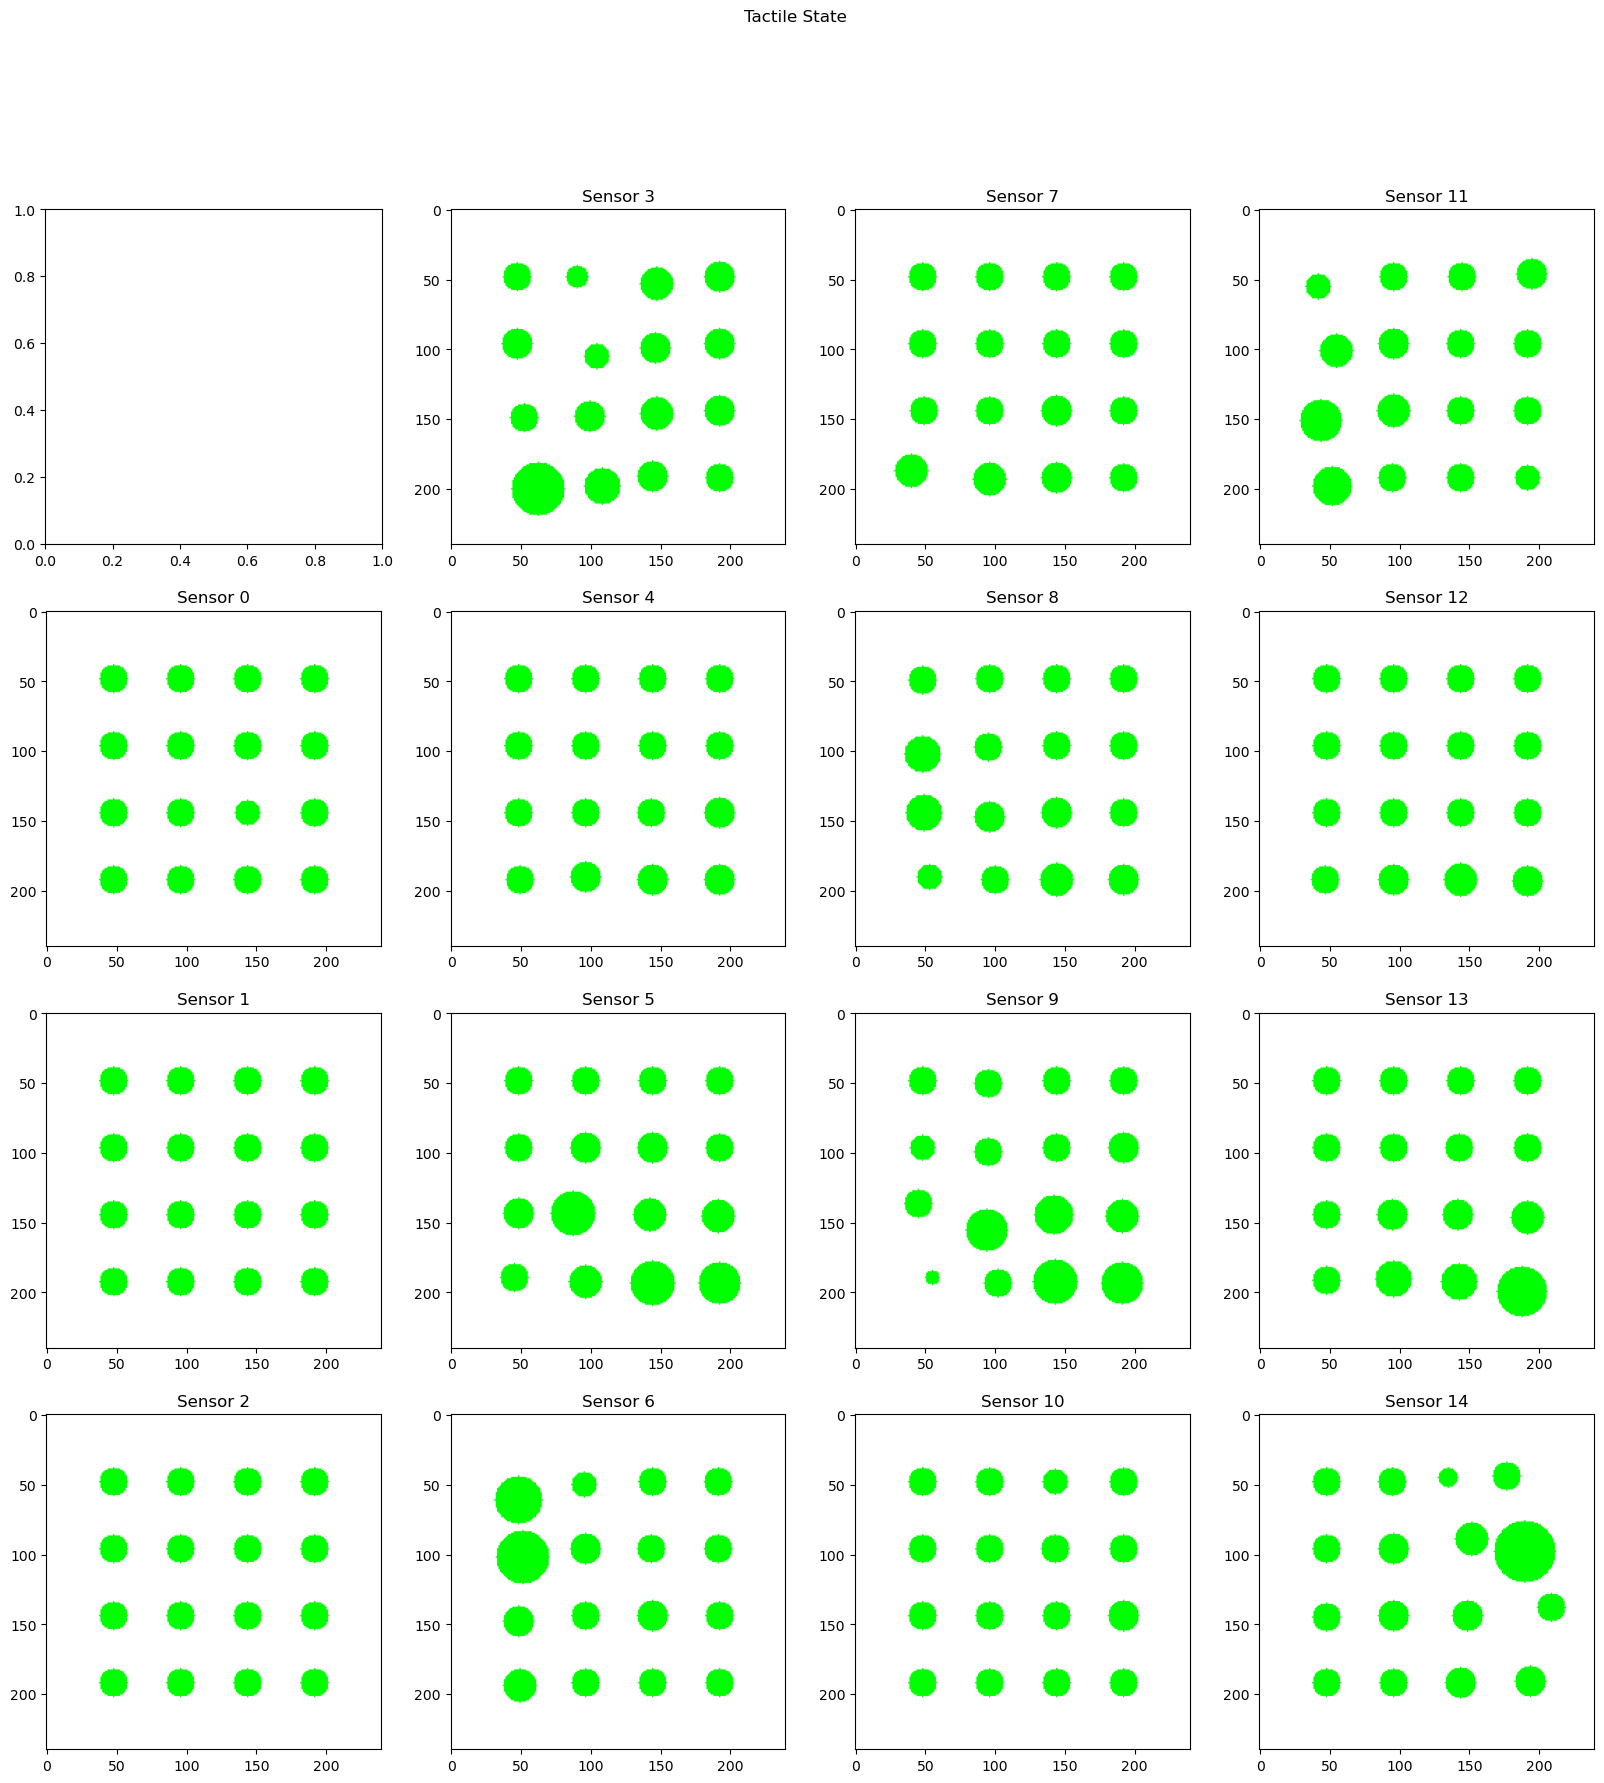

In [15]:
# root = '/home/irmak/Workspace/Holo-Bot/extracted_data/both_robots/demonstration_new_box_opening_1'
# roots = [
#     '/home/irmak/Workspace/Holo-Bot/extracted_data/both_robots/demonstration_new_box_opening_1',
#     '/home/irmak/Workspace/Holo-Bot/extracted_data/both_robots/demonstration_hammer_1',
#     '/home/irmak/Workspace/Holo-Bot/extracted_data/both_robots/demonstration_new_book_1',
#     '/home/irmak/Workspace/Holo-Bot/extracted_data/both_robots/demonstration_bottle_opening_1',
#     '/home/irmak/Workspace/Holo-Bot/extracted_data/both_robots/demonstration_new_reverse_peg_4',
#     '/home/irmak/Workspace/Holo-Bot/extracted_data/both_robots/demonstration_new_joystick_2'
# ]
roots = [
    # '/home/irmak/Workspace/Holo-Bot/extracted_data/both_robots/demonstration_handle_grabbing_1',
    # '/home/irmak/Workspace/Holo-Bot/extracted_data/both_robots/demonstration_bowl_handle_lifting_4',
    # '/home/irmak/Workspace/Holo-Bot/extracted_data/both_robots/demonstration_bowl_handle_lifting_6',
    # '/home/irmak/Workspace/Holo-Bot/deployment_data/box_handle_lifting/demonstration_4cm_forward_start',
    # '/home/irmak/Workspace/Holo-Bot/deployment_data/box_handle_lifting/demonstration_10cm_forward_start',
    # '/home/irmak/Workspace/Holo-Bot/deployment_data/box_handle_lifting/demonstration_10cm_left_start',
    # '/home/irmak/Workspace/Holo-Bot/deployment_data/box_handle_lifting/demonstration_10cm_right_start',
    # '/home/irmak/Workspace/Holo-Bot/deployment_data/box_handle_lifting/demonstration_5cm_up_start',
    # '/home/irmak/Workspace/Holo-Bot/deployment_data/box_handle_lifting/demonstration_image_only_repr_home_box_forward'
    # '/home/irmak/Workspace/Holo-Bot/extracted_data/box_handle_lifting/box_location_changing/eval/demonstration_1',
    # '/home/irmak/Workspace/Holo-Bot/extracted_data/box_handle_lifting/box_location_changing/eval/demonstration_2',
    # '/home/irmak/Workspace/Holo-Bot/extracted_data/box_handle_lifting/box_location_changing/eval/demonstration_3',
    '/home/irmak/Workspace/Holo-Bot/extracted_data/tactile_play_data/demonstration_13',
    '/home/irmak/Workspace/Holo-Bot/extracted_data/tactile_play_data/demonstration_14'
]

retrieval_fps = 5
for root in roots:
    # print('root: {}'.format(root))
    tactile_indices, image_indices = get_desired_indices(root=root, fps=retrieval_fps)
    print('tactile_indices: {}, image_indices: {}'.format(tactile_indices, image_indices))
    dump_states(root, tactile_indices, image_indices)


In [16]:
# Turn the images to a video and delete the directory
video_fps = 10
for root in roots:
    print('dumping video in root: {}'.format(root))
    video_path = os.path.join(root, 'visualization.mp4')
    if os.path.exists(video_path):
        os.remove(video_path)
    viz_dir = os.path.join(root, 'visualization')
    os.system('ffmpeg -r {} -i {}/%*.png -vf scale=2000x720,setsar=1:1 {}'.format(
        video_fps, # fps
        viz_dir,
        video_path
    ))


dumping video in root: /home/irmak/Workspace/Holo-Bot/extracted_data/tactile_play_data/demonstration_13


ffmpeg version 5.1.2 Copyright (c) 2000-2022 the FFmpeg developers
  built with gcc 10.4.0 (conda-forge gcc 10.4.0-18)
  configuration: --prefix=/home/irmak/miniconda3/envs/tactile_learning --cc=/home/conda/feedstock_root/build_artifacts/ffmpeg_1666357487580/_build_env/bin/x86_64-conda-linux-gnu-cc --cxx=/home/conda/feedstock_root/build_artifacts/ffmpeg_1666357487580/_build_env/bin/x86_64-conda-linux-gnu-c++ --nm=/home/conda/feedstock_root/build_artifacts/ffmpeg_1666357487580/_build_env/bin/x86_64-conda-linux-gnu-nm --ar=/home/conda/feedstock_root/build_artifacts/ffmpeg_1666357487580/_build_env/bin/x86_64-conda-linux-gnu-ar --disable-doc --disable-openssl --enable-demuxer=dash --enable-hardcoded-tables --enable-libfreetype --enable-libfontconfig --enable-libopenh264 --enable-gnutls --enable-libmp3lame --enable-libvpx --enable-pthreads --enable-vaapi --enable-gpl --enable-libx264 --enable-libx265 --enable-libaom --enable-libsvtav1 --enable-libxml2 --enable-pic --enable-shared --disable-

dumping video in root: /home/irmak/Workspace/Holo-Bot/extracted_data/tactile_play_data/demonstration_14


[libx264 @ 0x55652bf2a800] using SAR=1/1
[libx264 @ 0x55652bf2a800] using cpu capabilities: MMX2 SSE2Fast SSSE3 SSE4.2 AVX FMA3 BMI2 AVX2
[libx264 @ 0x55652bf2a800] profile High 4:4:4 Predictive, level 4.0, 4:4:4, 8-bit
[libx264 @ 0x55652bf2a800] 264 - core 164 r3095 baee400 - H.264/MPEG-4 AVC codec - Copyleft 2003-2022 - http://www.videolan.org/x264.html - options: cabac=1 ref=3 deblock=1:0:0 analyse=0x3:0x113 me=hex subme=7 psy=1 psy_rd=1.00:0.00 mixed_ref=1 me_range=16 chroma_me=1 trellis=1 8x8dct=1 cqm=0 deadzone=21,11 fast_pskip=1 chroma_qp_offset=4 threads=22 lookahead_threads=3 sliced_threads=0 nr=0 decimate=1 interlaced=0 bluray_compat=0 constrained_intra=0 bframes=3 b_pyramid=2 b_adapt=1 b_bias=0 direct=1 weightb=1 open_gop=0 weightp=2 keyint=250 keyint_min=10 scenecut=40 intra_refresh=0 rc_lookahead=40 rc=crf mbtree=1 crf=23.0 qcomp=0.60 qpmin=0 qpmax=69 qpstep=4 ip_ratio=1.40 aq=1:1.00
Output #0, mp4, to '/home/irmak/Workspace/Holo-Bot/extracted_data/tactile_play_data/demons

In [17]:
# Remove the img directory

for root in roots:
    viz_dir = os.path.join(root, 'visualization')
    shutil.rmtree(viz_dir)
